# Evaluate parameters

Lars Caspersen

## Aim

Read the estimated model parameters and produce figures for the manuscript. Output will be a bunch of figures including prediction vs observation plots. Boxplots summarizing the model performance in terms of RMSE and RPIQ, as well as plots visualizing the chill and heat submodels in form of temperature response curves.

## Prepare the parameters

For convenience we convert the parameters in the standard format, that PhenoFlex expects. I wrote a little helper function, that automatically checks which sets of parameters need to be converted and which not.

In [ ]:
#|echo: false
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'chillR'

The following object is masked from 'package:lubridate':

    leap_year

Loading required package: magrittr

Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract

In [ ]:
#| eval: false
#| include: false
library(tidyverse)
library(chillR)
library(LarsChill)
#devtools::install_github('larscaspersen/eval_phenoflex')


#helper function that converts the parameters of the intermediate format (theta_star, theta_c, pie_c, tau) to the proper format that phenoflex expects (E0, E1, A0, A1)


convert_all_par <- function(par_df){
  
  #identify which rows need to be converted
  conv_i <- which(is.na(par_df$E0) |
                    is.na(par_df$E1) |
                    is.na(par_df$A0) |
                    is.na(par_df$A1)) 
  
  if(length(conv_i) == 0) return(par_df)
  
  par_df_no_conv <- par_df[-conv_i, ]
  
  par_conv <- par_df[conv_i,]
  
  par_conv <- purrr::map(1:nrow(par_conv), function(i){
    par <- par_conv[i, LarsChill::phenoflex_parnames_new] %>% 
      unlist() %>% 
      convert_parameters() %>% 
      unname()
    
    return(data.frame(E0 = par[5], E1 = par[6], A0 = par[7], A1 = par[8]))
  }) %>% 
    bind_rows()
  
  par_df[conv_i,] %>% 
    select(-E0, -E1, -A0, -A1) %>% 
    cbind(par_conv) %>% 
    rbind(par_df_no_conv) %>% 
    return()
}

#read model parameters
par_cherry <- read.csv('data/par-cherry.csv') %>% 
  mutate(species = 'Sweet Cherry') %>% 
  convert_all_par()

par_apricot <- read.csv('data/par-apricot.csv') %>% 
  mutate(species = 'Apricot')%>% 
  convert_all_par()

par_almond <- read.csv('data/par-almond.csv') %>% 
  mutate(species = 'Almond')%>%
  select(-repetition) %>% 
  convert_all_par()

par_all <- par_almond %>% 
  rbind(par_apricot) %>% 
  rbind(par_cherry)

rm(par_almond, par_apricot, par_cherry)

write.csv(par_all, 'data/par_all_slim_paper.csv', row.names = FALSE)

## Predict bloom dates for calibration and validation data

Next task is to prepare the temperature data and predict the bloom dates using the different parameter sets. We also need to read the actual observation data for the comparison later.

In [ ]:
#compare the prediction accuracy for the different cultivars and models
master_apricot <- read.csv('data/master_apricot.csv') %>% 
  select(species, cultivar, yday, year, split, ncal, location)
master_cherry <- read.csv('data/master_cherry.csv') %>% 
  select(species, cultivar, yday, year, split, ncal, location)
master_almond <- read.csv('data/master_almond.csv') %>% 
  select(species, cultivar, yday, year, split, ncal, location)

#combine the different master files to one grand data.frame
master <- master_almond %>% 
  rbind(master_apricot) %>% 
  rbind(master_cherry) %>% 
  mutate(loc.year = paste(location, year, sep = '.'))

rm(master_almond, master_apricot, master_cherry)

#read temperature data
sfax <- read.csv('data/sfax.csv')
meknes <- read.csv('data/meknes.csv')
santomera <- read.csv('data/santomera.csv')
zaragoza <- read.csv('data/zaragoza_clean.csv')
cka <- read.csv('data/cka_clean.csv')
cieza <- read.csv('data/cieza_clean.csv')

weather_list <- list('Meknes' = meknes,
                     'Santomera' = santomera, 
                     'Sfax' = sfax,
                     'Zaragoza' = zaragoza,
                     'Klein-Altendorf' = cka,
                     'Cieza' = cieza)

station_list <- read.csv('data/weather_stations.csv', sep = ',', dec = '.')

#generate seasonlist
seasonlist <- purrr::map2(weather_list, names(weather_list), function(weather, stat){
  ymin <- min(weather$Year)
  ymax <- max(weather$Year)
  
  weather %>% 
    chillR::stack_hourly_temps(latitude = station_list$lat[station_list$station == stat]) %>% 
    purrr::pluck('hourtemps') %>% 
    chillR::genSeasonList(years = ymin:ymax) %>% 
    setNames(ymin:ymax) %>% 
    return()
}) %>% 
  unlist(recursive = FALSE)

rm(zaragoza, cieza, cka, meknes, sfax, santomera, station_list, weather_list)

In [ ]:
#|echo: false
master$cultivar <- ifelse(master$cultivar == 'B\xfalida', yes = 'Bulida',
                           no = master$cultivar)

Now we can do the actual bloom prediction. I use the `purrr::map` function, which works similar to a loop or lapply, with the extra benefit of being a bit faster and having a convenient loading bar implemented. I iterate over the rows in the parameter data.frame and predict bloom dates for all the seasonlist. That may take a few seconds longer, but I found it more convenient to weed out the preditions that we do not need when merging with observed bloom instead of weeding the unneeded combinations of parameter and seasonlists beforehand.

In [ ]:
#| eval: false

#predict bloom dates
pred_out <- purrr::map(1:nrow(par_all), function(i){
  sub <- master %>% 
    filter(species == par_all$species[i],
           cultivar == par_all$cultivar[i],
           ncal == par_all$n_cal[i])
  

  pred <- par_all[i, LarsChill::phenoflex_parnames_old] %>% 
    unlist() %>% 
    return_predicted_days(modelfn = evalpheno::custom_PhenoFlex_GDHwrapper, SeasonList =   seasonlist[sub$loc.year]) %>% 
    round(digits = 2) 
  
  data.frame(predicted = pred,
             species = par_all$species[i],
             cultivar = par_all$cultivar[i],
             ncal = par_all$n_cal[i],
             split = sub$split,
             location = sub$location,
             year = sub$year,
             fit = par_all$fit[i],
             observed = sub$yday) %>% 
    return()
}, .progress = TRUE)

pred_out <- do.call(rbind, pred_out)

write.csv(pred_out, file = 'data/predicted-observed.csv', row.names = FALSE)

## Plot RMSE

At first, let’s look for effects of the four variables: `ncal` (calibration dataset size: scarce or full), `fit` (calibration method: single, combined or baseline), `species` (almond, apricot, sweet cherry) and `split`. (calibration, validation). Initially, I was expecting to see that baseline model and combined fit may outperform the single calibration for scarce data set, because they require less parameters. Also, it was commonly suggested, that 10 observations are not sufficient for the single calibration method. That turned out to be not true.

`summarise()` has grouped output by 'species', 'cultivar', 'fit', 'split'. You
can override using the `.groups` argument.

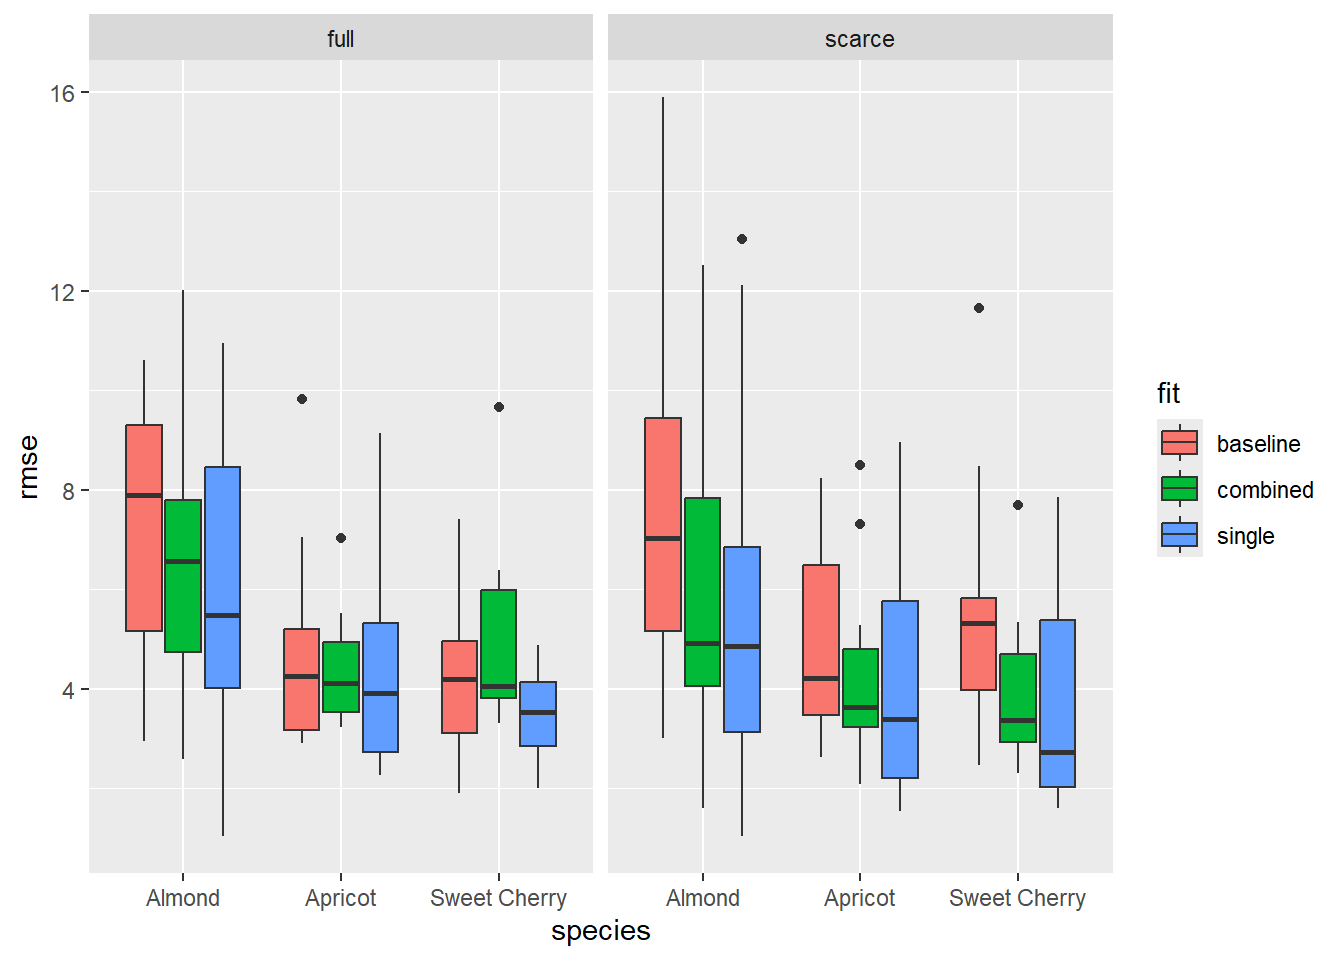

In [ ]:
pred_out <- read.csv('data/predicted-observed.csv')

perf <- pred_out %>% 
  group_by(species, cultivar, fit, split, ncal) %>% 
  summarise(rmse = chillR::RMSEP(predicted, observed))

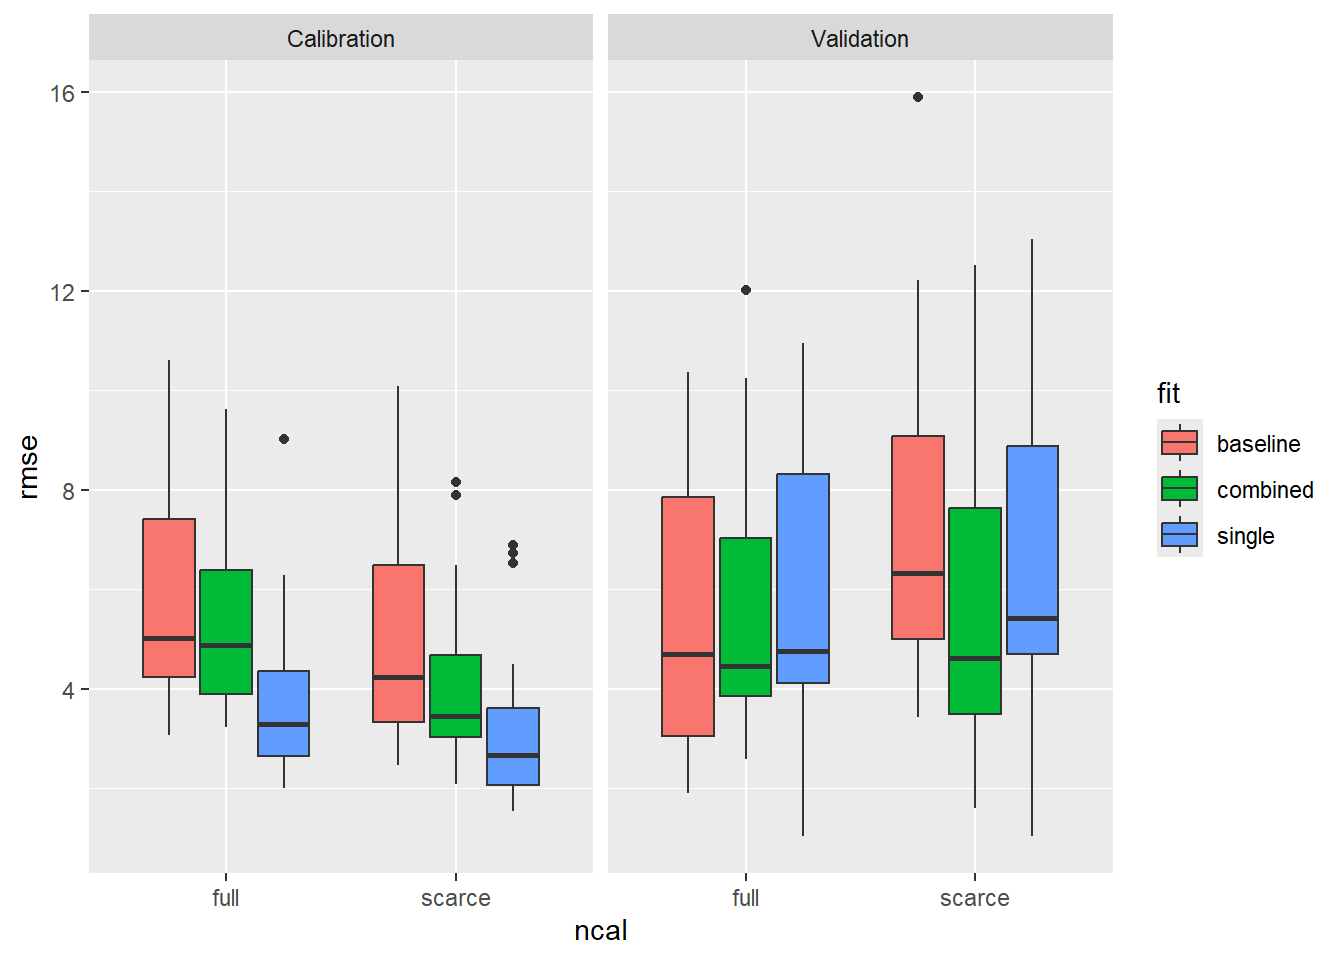

In [ ]:
ggplot(perf, aes(x = ncal, y = rmse)) +
  geom_boxplot(aes(fill = fit)) +
  facet_grid(~split)

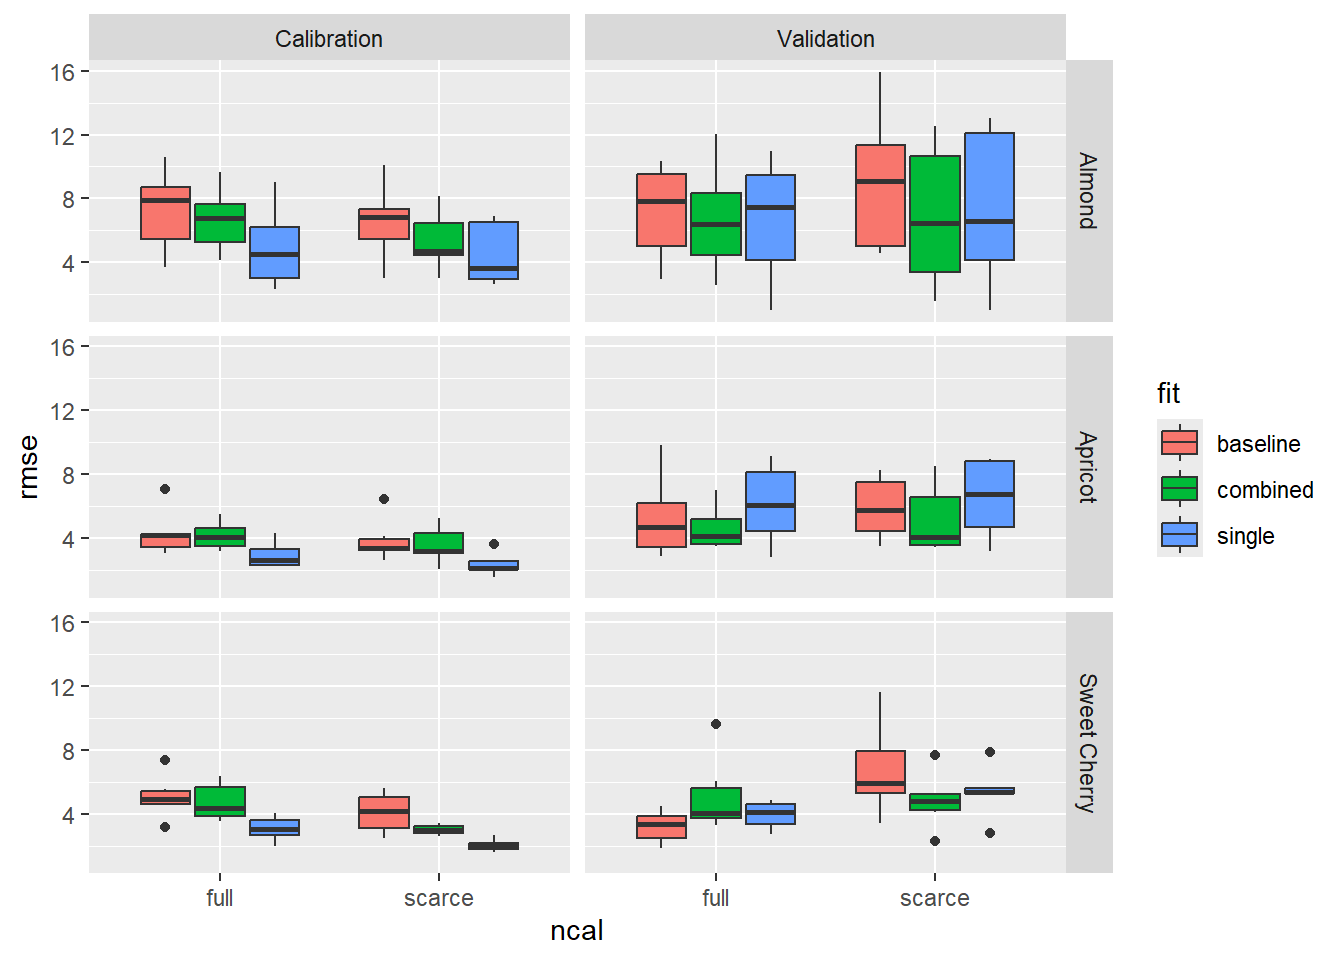

In [ ]:
ggplot(perf, aes(x = ncal, y = rmse)) +
  geom_boxplot(aes(fill = fit)) +
  facet_grid(species~split)

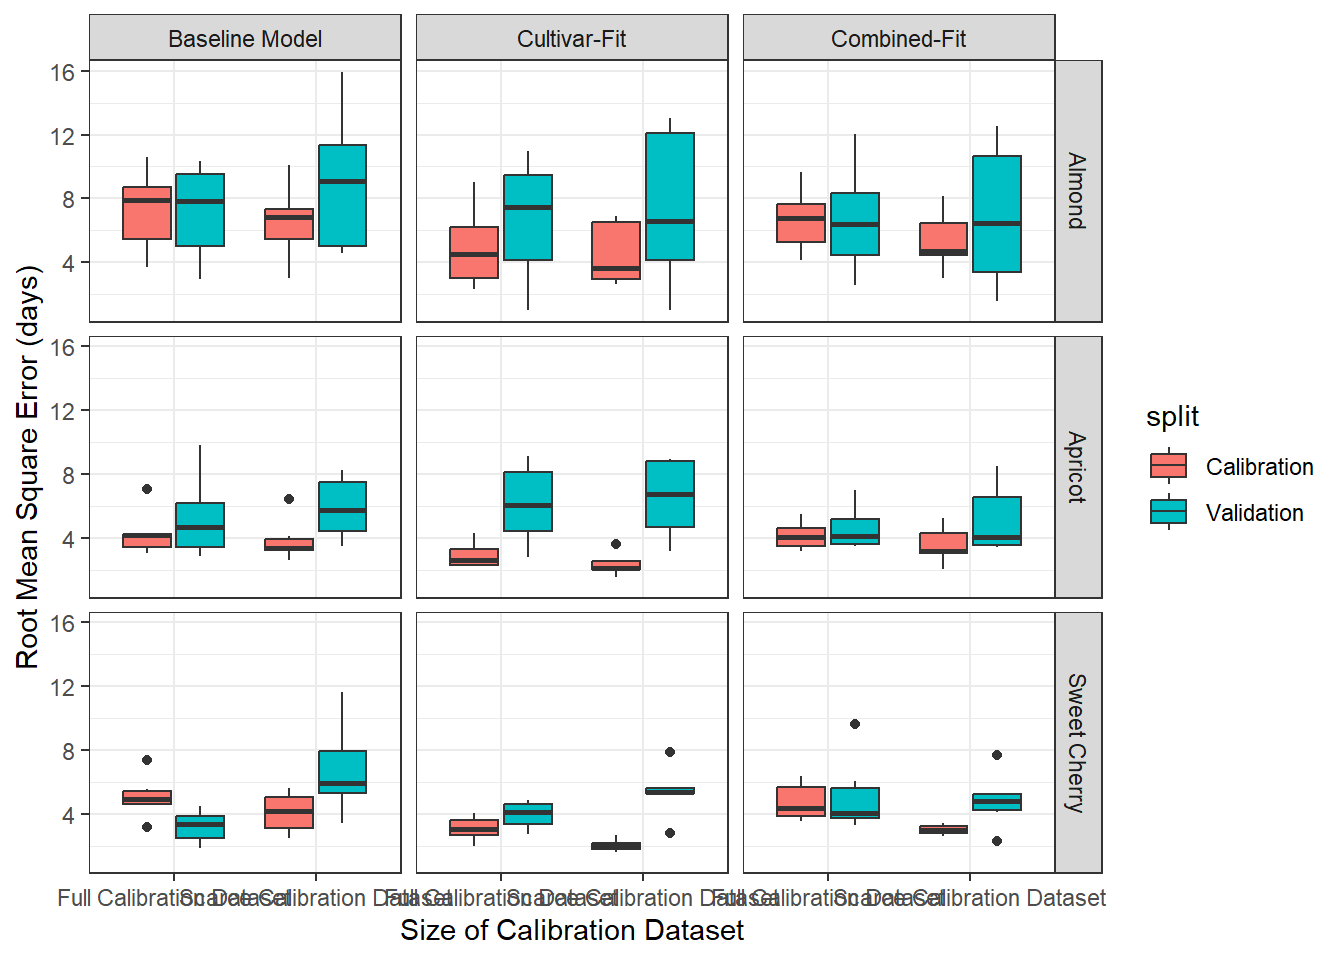

In [ ]:
#emphasize the difference in calibration and validation
perf %>% 
  mutate(ncal_plot = factor(ncal, 
                            levels = c('full', 'scarce'),
                            labels = c('Full Calibration Dataset', 'Scarce Calibration Dataset')),
         fit_plot = factor(fit, 
                           levels = c('baseline', 'single', 'combined'),
                           labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit'))) %>% 
  ggplot(aes(x = ncal_plot, y = rmse)) +
  geom_boxplot(aes(fill = split)) +
  facet_grid(species~fit_plot) +
  ylab('Root Mean Square Error (days)') +
  xlab('Size of Calibration Dataset') +
  theme_bw()

Next, I want to check if the difference in calibration and validation differs a lot. This may be an indicator for overfitting. The single-fit data based on the scarce calibration dataset shows signs of overfitting. But it in the plots above we didn’t see that the validation performance of single-fit data was worse than in the other treatments. Rather, it seems that the calibration performance of single-fit was just better, but that did not translate into better validation performance.

In [ ]:
#table for writing 
test <- perf %>% 
  group_by(species, ncal, fit, split) %>% 
  summarise(median = median(rmse) %>% round(digits = 1),
            sd = sd(rmse) %>% round(digits = 1))

`summarise()` has grouped output by 'species', 'ncal', 'fit'. You can override
using the `.groups` argument.

`summarise()` has grouped output by 'ncal'. You can override using the
`.groups` argument.

# A tibble: 6 × 4
# Groups:   ncal [2]
  ncal   fit      median    sd
  <chr>  <chr>     <dbl> <dbl>
1 full   baseline   -0.5   2.5
2 full   combined    0     1.9
3 full   single      1.8   2.3
4 scarce baseline    1.5   2.8
5 scarce combined    0.9   2.7
6 scarce single      3.2   3.5

In [ ]:
perf %>% 
  #filter(fit != 'single') %>% 
  pivot_wider(values_from = rmse, names_from = split) %>% 
  mutate(diff = Validation - Calibration) %>% 
  group_by(ncal) %>% 
  summarise(median = median(diff) %>% round(digits = 1),
            sd = sd(diff) %>% round(digits = 1))

# A tibble: 2 × 3
  ncal   median    sd
  <chr>   <dbl> <dbl>
1 full      0.4   2.4
2 scarce    2.1   3.1

Now let’s make a more refined plot, suitable for publishing.

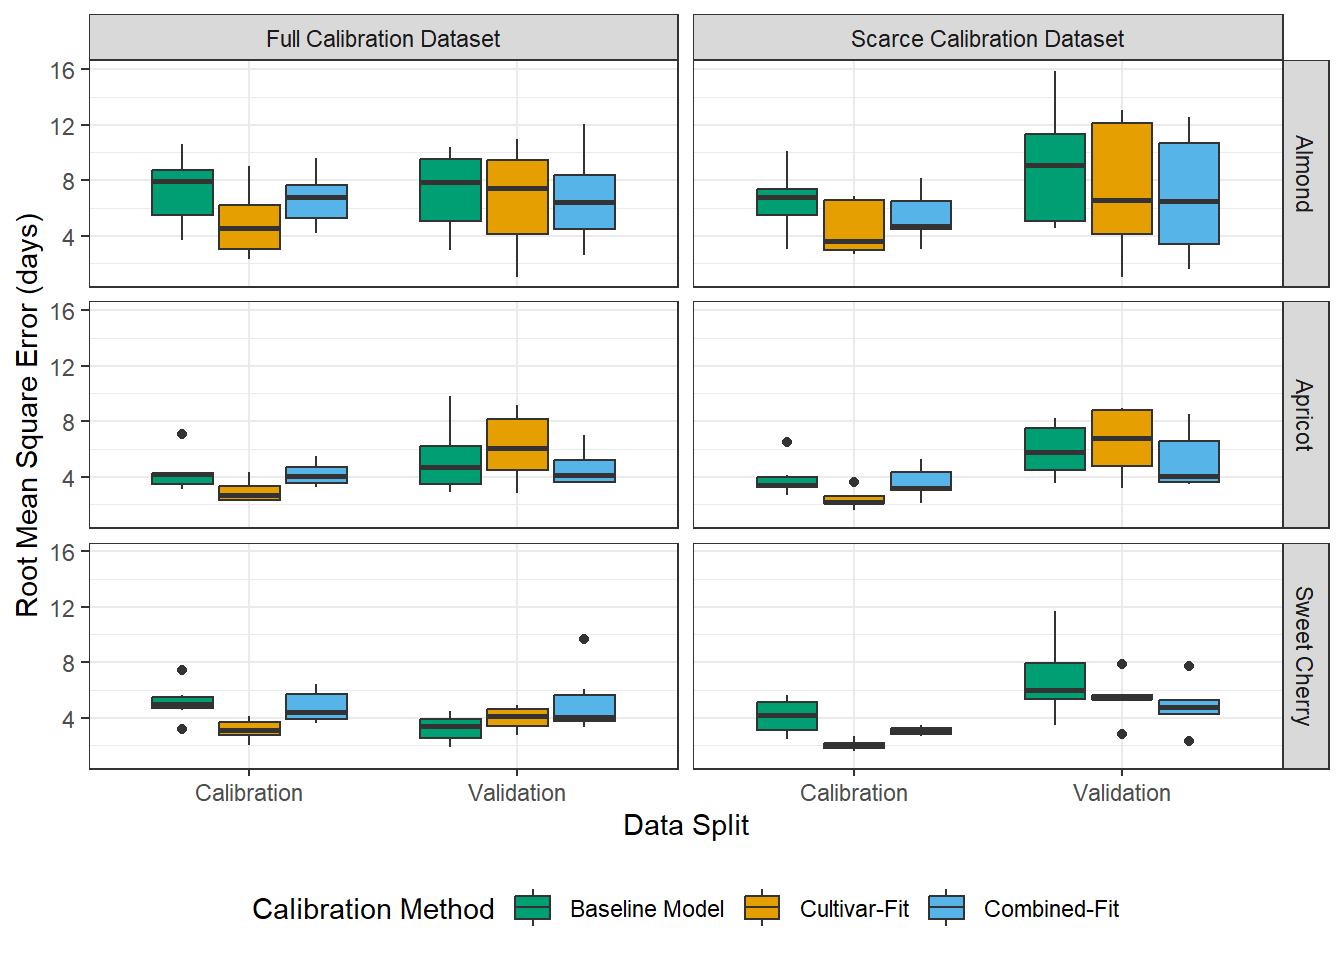

In [ ]:
#emphasize the difference in fit
p1 <- perf %>% 
  mutate(ncal_plot = factor(ncal, 
                            levels = c('full', 'scarce'),
                            labels = c('Full Calibration Dataset', 'Scarce Calibration Dataset')),
         fit_plot = factor(fit, 
                           levels = c('baseline', 'single', 'combined'),
                           labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit'))) %>% 
  ggplot(aes(x = split, y = rmse)) +
  geom_boxplot(aes(fill = fit_plot)) +
  facet_grid(species~ncal_plot) +
  scale_fill_manual(name = 'Calibration Method', values = c("#009E73", "#E69F00", "#56B4E9")) +
  ylab('Root Mean Square Error (days)') +
  xlab('Data Split') +
  theme_bw()+
  theme(legend.position = 'bottom') 
  

p1

I also want to check how much the model performance differed by cultivar.

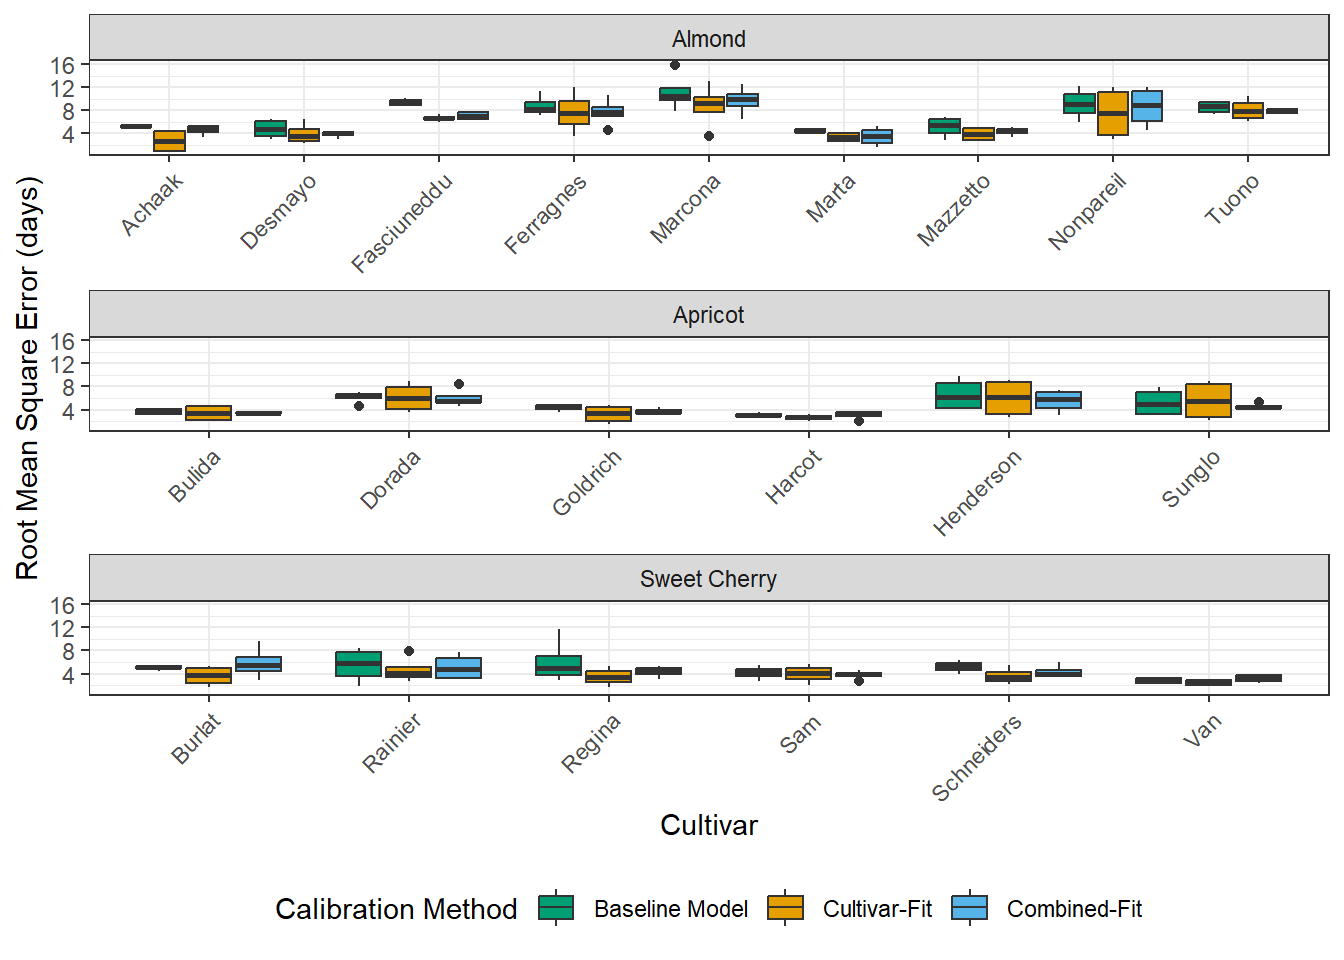

In [ ]:
#check differences in cultivars
p2 <- perf %>% 
  mutate(cultivar = recode(cultivar, 
                           `B\xfalida` = 'Búlida'),
    ncal_plot = factor(ncal, 
                            levels = c('full', 'scarce'),
                            labels = c('Full', 'Scarce')),
         fit_plot = factor(fit, 
                           levels = c('baseline', 'single', 'combined'),
                           labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit'))) %>% 
  ggplot(aes(x = cultivar, y = rmse)) +
  geom_boxplot(aes(fill = fit_plot)) +
  facet_wrap(species~., scales = 'free_x', ncol = 1, nrow = 3) +
  scale_fill_manual(name = 'Calibration Method', values = c("#009E73", "#E69F00", "#56B4E9")) +
  ylab('Root Mean Square Error (days)') +
  xlab('Cultivar') +
  theme_bw()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = 'bottom')

p2

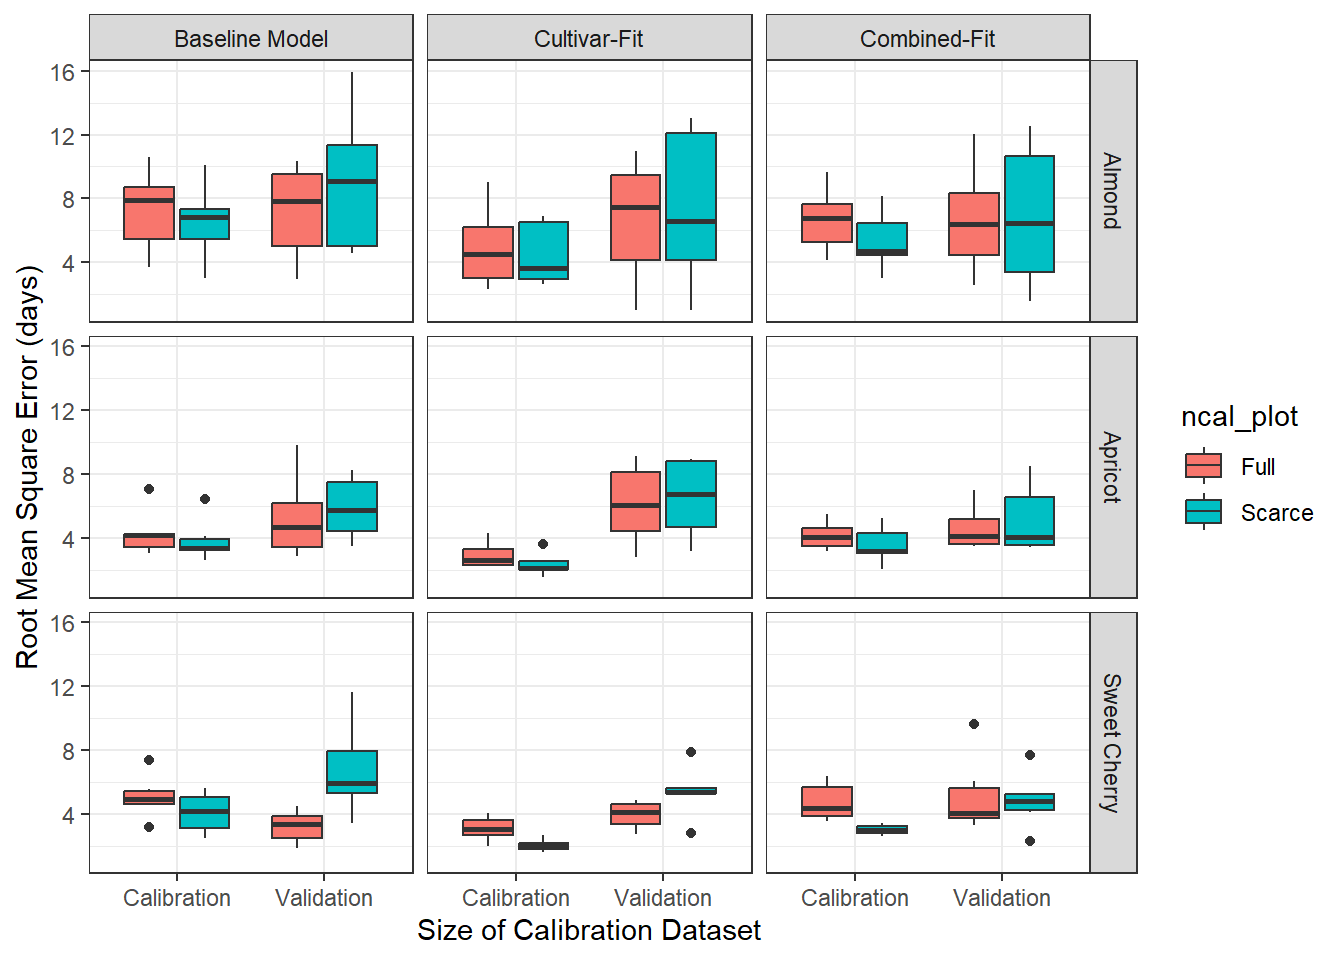

In [ ]:
#emphasize the difference full and scarce
perf %>% 
  mutate(ncal_plot = factor(ncal, 
                            levels = c('full', 'scarce'),
                            labels = c('Full', 'Scarce')),
         fit_plot = factor(fit, 
                           levels = c('baseline', 'single', 'combined'),
                           labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit'))) %>% 
  ggplot(aes(x = split, y = rmse)) +
  geom_boxplot(aes(fill = ncal_plot)) +
  facet_grid(species~fit_plot) +
  ylab('Root Mean Square Error (days)') +
  xlab('Size of Calibration Dataset') +
  theme_bw()

## Predicted vs Observed

Next, I want to generate a plot where predicted and observed bloom dates are visualized more explicitly. For that I will need some helper objects that will make plotting easier.

In [ ]:
#---------------------------#
#predicted vs observed plot
#---------------------------#

start <- floor(min(c(pred_out$observed, pred_out$predicted)))
end <- ceiling(max(c(pred_out$observed, pred_out$predicted)))
threshold <- 7
ribbon_df <- data.frame(mid = start:end) %>% 
  mutate(lower = mid - threshold,
         upper = mid + threshold)

pred_out <- pred_out %>% 
  mutate(ncal_plot = factor(ncal, 
                            levels = c('full', 'scarce'),
                            labels = c('Full Calibration Dataset', 'Scarce Calibration Dataset')),
         fit_plot = factor(fit, 
                           levels = c('baseline', 'single', 'combined'),
                           labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit')))

iqr_df <- pred_out %>% 
  group_by(fit, ncal, fit_plot, ncal_plot) %>% 
  summarise(iqr = IQR(observed))

`summarise()` has grouped output by 'fit', 'ncal', 'fit_plot'. You can override
using the `.groups` argument.

`summarise()` has grouped output by 'split', 'fit', 'ncal', 'fit_plot'. You can
override using the `.groups` argument.

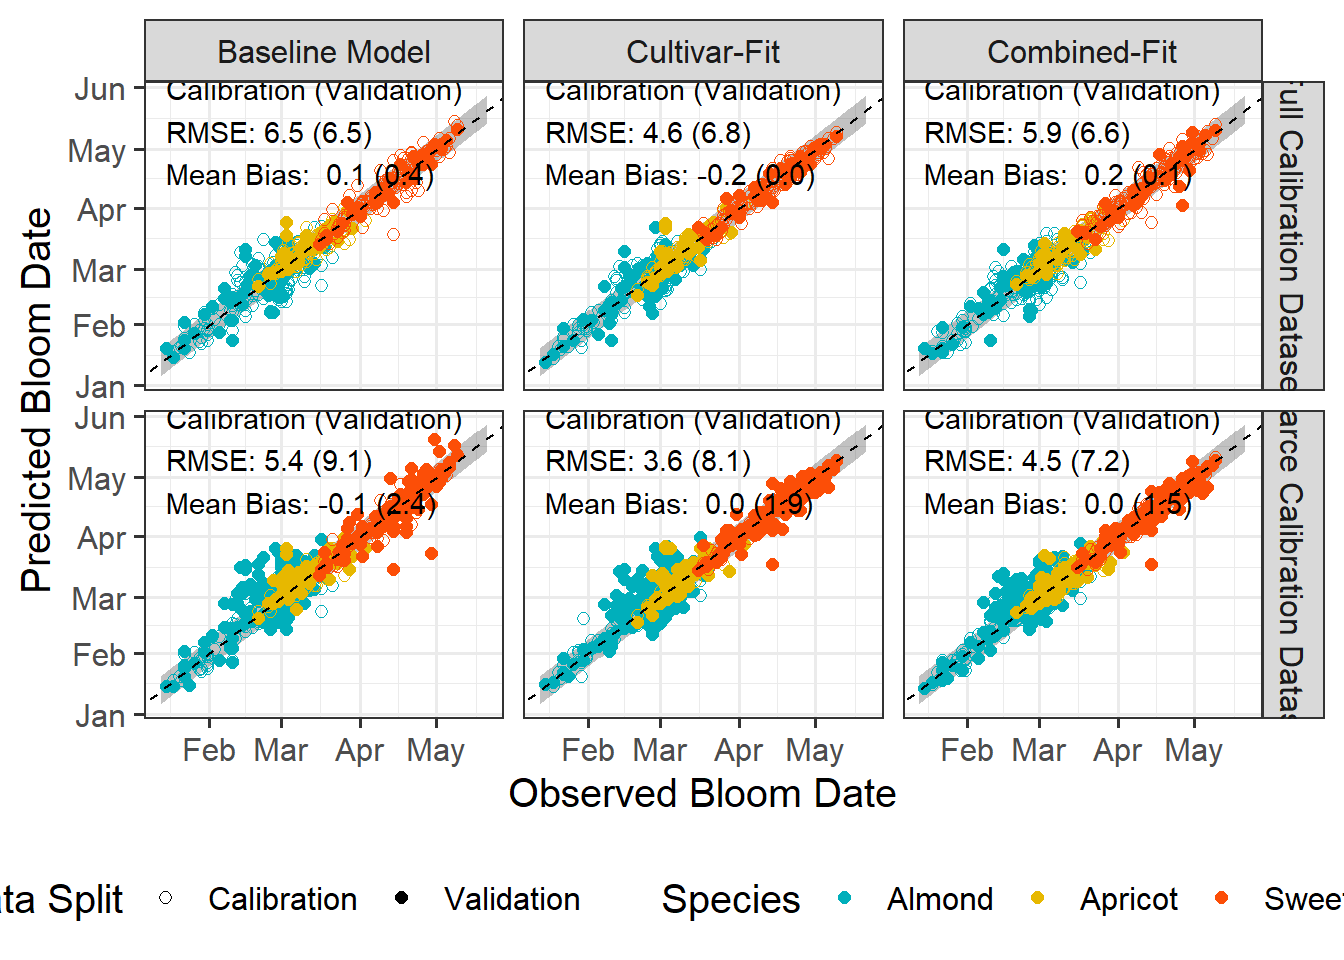

In [ ]:
p3 <- pred_out %>% 
  ggplot() +
  geom_ribbon(data = ribbon_df, aes(x= mid, ymin = lower, ymax = upper), alpha = 0.3) +
  geom_point(aes(x = observed, y = predicted,
                 shape = split, col = species, fill = species), size = 2) +
  geom_abline(slope = 1, intercept = 0, linetype = 'dashed') +
  geom_text(data = text_df, aes(x = 15, y = 130, 
                label = paste0('Calibration (Validation)\nRMSE: ',
                               format(rmse.Calibration, digits = 2),
                               ' (', format(rmse.Validation, digits = 2), 
                               # ')\nRPIQ: ',
                               # format(rpiq.Calibration, digits = 2),
                               # ' (', format(rpiq.Validation, digits = 2), 
                               ')\nMean Bias: ',
                               format(mean_bias.Calibration, digits = 1),
                               ' (', format(mean_bias.Validation, digits = 1), ')'
                               )),
            hjust = 0)+
  scale_shape_manual(values = c(1, 16),
                     name = 'Data Split') +
  scale_color_manual(values = c("#00AFBB", "#E7B800", "#FC4E07"),
                     name = 'Species')+
  scale_fill_manual(values = c("#00AFBB", "#E7B800", "#FC4E07"),
                    name = 'Species')+
  scale_x_continuous(breaks = c(1, 32, 60,91, 121, 152), 
                     labels = c('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun')) +
  scale_y_continuous(breaks = c(1, 32, 60,91, 121, 152), 
                     labels = c('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun')) +
  facet_grid(ncal_plot~fit_plot) +
  ylab('Predicted Bloom Date') +
  xlab('Observed Bloom Date') +
  theme_bw(base_size = 15)+
  theme(legend.position = 'bottom')

p3

Some more summary tables that I may need for reporting.

In [ ]:
test <- pred_out %>% 
  mutate(res = predicted - observed) %>% 
  group_by(split, fit, ncal, fit_plot, ncal_plot, species) %>% 
  summarise(rmse = chillR::RMSEP(predicted, observed) %>%  round(digits = 1),
            mean_bias = mean(predicted - observed) %>%  round(digits = 1),
            n = n(),
            share_large_res = (sum(abs(res) > threshold) / n()) %>%  round(digits = 2),
            nlarge_res = (sum(abs(res) > threshold)) ) %>%  
  ungroup()

`summarise()` has grouped output by 'split', 'fit', 'ncal', 'fit_plot',
'ncal_plot'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'split', 'fit', 'ncal', 'fit_plot'. You can
override using the `.groups` argument.

# A tibble: 12 × 9
   split    fit   ncal  fit_plot ncal_plot  rmse mean_bias     n share_large_res
   <chr>    <chr> <chr> <fct>    <fct>     <dbl>     <dbl> <int>           <dbl>
 1 Calibra… base… full  Baselin… Full Cal…   6.5       0.1   385            0.25
 2 Calibra… base… scar… Baselin… Scarce C…   5.4      -0.1   210            0.17
 3 Calibra… comb… full  Combine… Full Cal…   5.9       0.2   385            0.21
 4 Calibra… comb… scar… Combine… Scarce C…   4.5       0     210            0.11
 5 Calibra… sing… full  Cultiva… Full Cal…   4.6      -0.2   385            0.12
 6 Calibra… sing… scar… Cultiva… Scarce C…   3.6       0     210            0.06
 7 Validat… base… full  Baselin… Full Cal…   6.5       0.4   139            0.2 
 8 Validat… base… scar… Baselin… Scarce C…   9.1       2.4   314            0.33
 9 Validat… comb… full  Combine… Full Cal…   6.6       0.1   139            0.23
10 Validat… comb… scar… Combine… Scarce C…   7.2       1.5   314            0.25
11 Valida

## Temperature response plots

We did not find stark difference in the prediction performance, but we may inspect the parameters themselves. Temperature response curves are a convenient tool the visualize how the parameters translate into the temperature sensitivity of the submodel.

The LarsChill package has some convenience functions for generating he temperature response curves. It has also some functions to visualize them, but we make our own code for that

In [ ]:
#| eval: false
temp <- seq(-5, 40, by = 0.1)


#make data.fame with temperature response plots
response_df <- purrr::map(1:nrow(par_all), function(i){
  
  par_all[i, LarsChill::phenoflex_parnames_old] %>% 
    unlist() %>% 
    LarsChill::get_temp_response_df(temp_values = temp) %>% 
    mutate(species = par_all$species[i],
           cultivar = par_all$cultivar[i],
           fit = par_all$fit[i],
           n_cal = par_all$n_cal[i]) %>% 
    return()
  
}, .progress = TRUE) %>% 
  bind_rows()

write.csv(response_df, file = 'data/response_df.csv', row.names = FALSE)

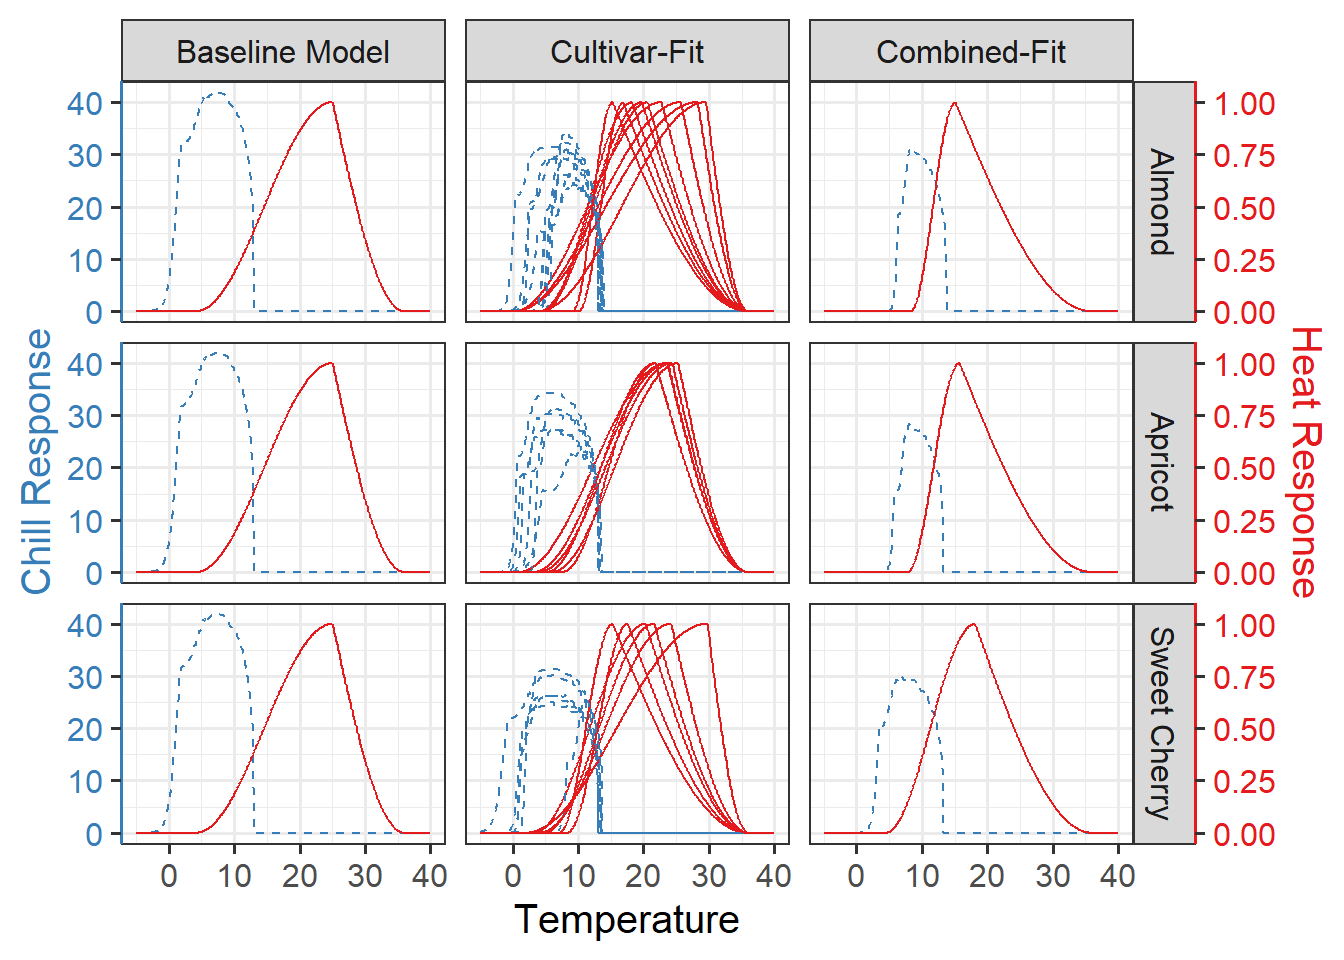

In [ ]:
#--------------------------#
#temperature reaction plots
#--------------------------#

response_df <- read.csv('data/response_df.csv')

p4 <- response_df %>% 
  filter(n_cal == 'full') %>% 
  mutate(Heat_response = Heat_response * 40) %>% 
  mutate(fit_plot = factor(fit, 
                    levels = c('baseline', 'single', 'combined'),
                    labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit'))) %>% 
  pivot_longer(cols = c('Chill_response', 'Heat_response')) %>% 
  mutate(name_plot = factor(name, 
                            levels = c('Chill_response', 'Heat_response'),
                            labels = c('Chill Response', 'Heat Response'))) %>% 
  mutate(id = paste(species, cultivar, fit, n_cal, name_plot, sep = '_')) %>% 
  ggplot(aes(x = Temperature, y = value, group = id, col = name_plot)) +
  geom_line(aes(linetype = name_plot), show.legend = FALSE) +
  scale_y_continuous(
    
    # Features of the first axis
    name = "Chill Response",
    
    # Add a second axis and specify its features
    sec.axis = sec_axis( transform=~./40, name="Heat Response")
  ) +
  theme_bw(base_size = 15) +
  scale_color_manual(values = c('#377eb8',  '#e41a1c')) +
  scale_linetype_manual(values = c('dashed', 'solid')) +
  facet_grid(species~fit_plot) +
  theme(
    # Primary Y-axis (left)
    axis.text.y.left = element_text(color = '#377eb8'),
    axis.title.y.left = element_text(color = '#377eb8'),
    axis.line.y.left = element_line(color = '#377eb8'),
    
    # Secondary Y-axis (right)
    axis.text.y.right = element_text(color = '#e41a1c'),
    axis.title.y.right = element_text(color = '#e41a1c'),
    axis.line.y.right = element_line(color = '#e41a1c'),
      legend.position = 'none'
    ) 
p4

For the sake of completion, I will also generate the temperature response curve of the scarcity dataset and a combine figure were the curves for both treatments are shown.

In [ ]:
#| eval: false
p5 <- response_df %>% 
  filter(n_cal == 'scarce') %>% 
  mutate(Heat_response = Heat_response * 40) %>% 
  mutate(fit_plot = factor(fit, 
                           levels = c('baseline', 'single', 'combined'),
                           labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit'))) %>% 
  pivot_longer(cols = c('Chill_response', 'Heat_response')) %>% 
  mutate(name_plot = factor(name, 
                            levels = c('Chill_response', 'Heat_response'),
                            labels = c('Chill Response', 'Heat Response'))) %>% 
  mutate(id = paste(species, cultivar, fit, n_cal, name_plot, sep = '_')) %>% 
  ggplot(aes(x = Temperature, y = value, group = id, col = name_plot)) +
  geom_line(aes(linetype = name_plot), show.legend = FALSE) +
  scale_y_continuous(
    
    # Features of the first axis
    name = "Chill Response",
    
    # Add a second axis and specify its features
    sec.axis = sec_axis( transform=~./40, name="Heat Response")
  ) +
  theme_bw(base_size = 15) +
  scale_color_manual(values = c('#377eb8',  '#e41a1c')) +
  scale_linetype_manual(values = c('dashed', 'solid')) +
  facet_grid(species~fit_plot) +
  theme(
    # Primary Y-axis (left)
    axis.text.y.left = element_text(color = '#377eb8'),
    axis.title.y.left = element_text(color = '#377eb8'),
    axis.line.y.left = element_line(color = '#377eb8'),
    
    # Secondary Y-axis (right)
    axis.text.y.right = element_text(color = '#e41a1c'),
    axis.title.y.right = element_text(color = '#e41a1c'),
    axis.line.y.right = element_line(color = '#e41a1c'),
    legend.position = 'none'
  ) 
#ggsave('figures/tempresponse_scarce.jpeg', plot = p5,height = 20, width = 25, units = 'cm', device = 'jpeg')


p6 <- response_df %>% 
  mutate(Heat_response = Heat_response * 40) %>% 
  mutate(fit_plot = factor(fit, 
                           levels = c('baseline', 'single', 'combined'),
                           labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit'))) %>% 
  pivot_longer(cols = c('Chill_response', 'Heat_response')) %>% 
  mutate(name_plot = factor(name, 
                            levels = c('Chill_response', 'Heat_response'),
                            labels = c('Chill Response', 'Heat Response'))) %>% 
  mutate(id = paste(species, cultivar, fit, n_cal, name_plot, sep = '_')) %>% 
  ggplot(aes(x = Temperature, y = value, group = id, col = name_plot)) +
  geom_line(aes(linetype = name_plot), show.legend = FALSE) +
  scale_y_continuous(
    
    # Features of the first axis
    name = "Chill Response",
    
    # Add a second axis and specify its features
    sec.axis = sec_axis( transform=~./40, name="Heat Response")
  ) +
  theme_bw(base_size = 15) +
  scale_color_manual(values = c('#377eb8',  '#e41a1c')) +
  scale_linetype_manual(values = c('dashed', 'solid')) +
  facet_grid(species~fit_plot) +
  theme(
    # Primary Y-axis (left)
    axis.text.y.left = element_text(color = '#377eb8'),
    axis.title.y.left = element_text(color = '#377eb8'),
    axis.line.y.left = element_line(color = '#377eb8'),
    
    # Secondary Y-axis (right)
    axis.text.y.right = element_text(color = '#e41a1c'),
    axis.title.y.right = element_text(color = '#e41a1c'),
    axis.line.y.right = element_line(color = '#e41a1c'),
    legend.position = 'none'
  ) 
#ggsave('figures/tempresponse_both.jpeg', plot = p6, height = 20, width = 25, units = 'cm', device = 'jpeg')

## Further evaluations on the model parameters

I decided to also make plots for the cultivar-specific parameters: vc, zc, s1.

First, I tried to graph for myself what s1 actually means. The black line is the function representing the share of potential GDH that gets actually accumulated depending on the level of chill accumulation. The idea is, that the more chill is accumulated the more heat can be accumulated. The chill requirement yc (red dashed line) moves the curve left or right. The steepness of the curve is determined by the s1 parameter (blue line). High values of s1 lead to steeper, more step-like transition function. Lower s1 value lead to a more leaning function.

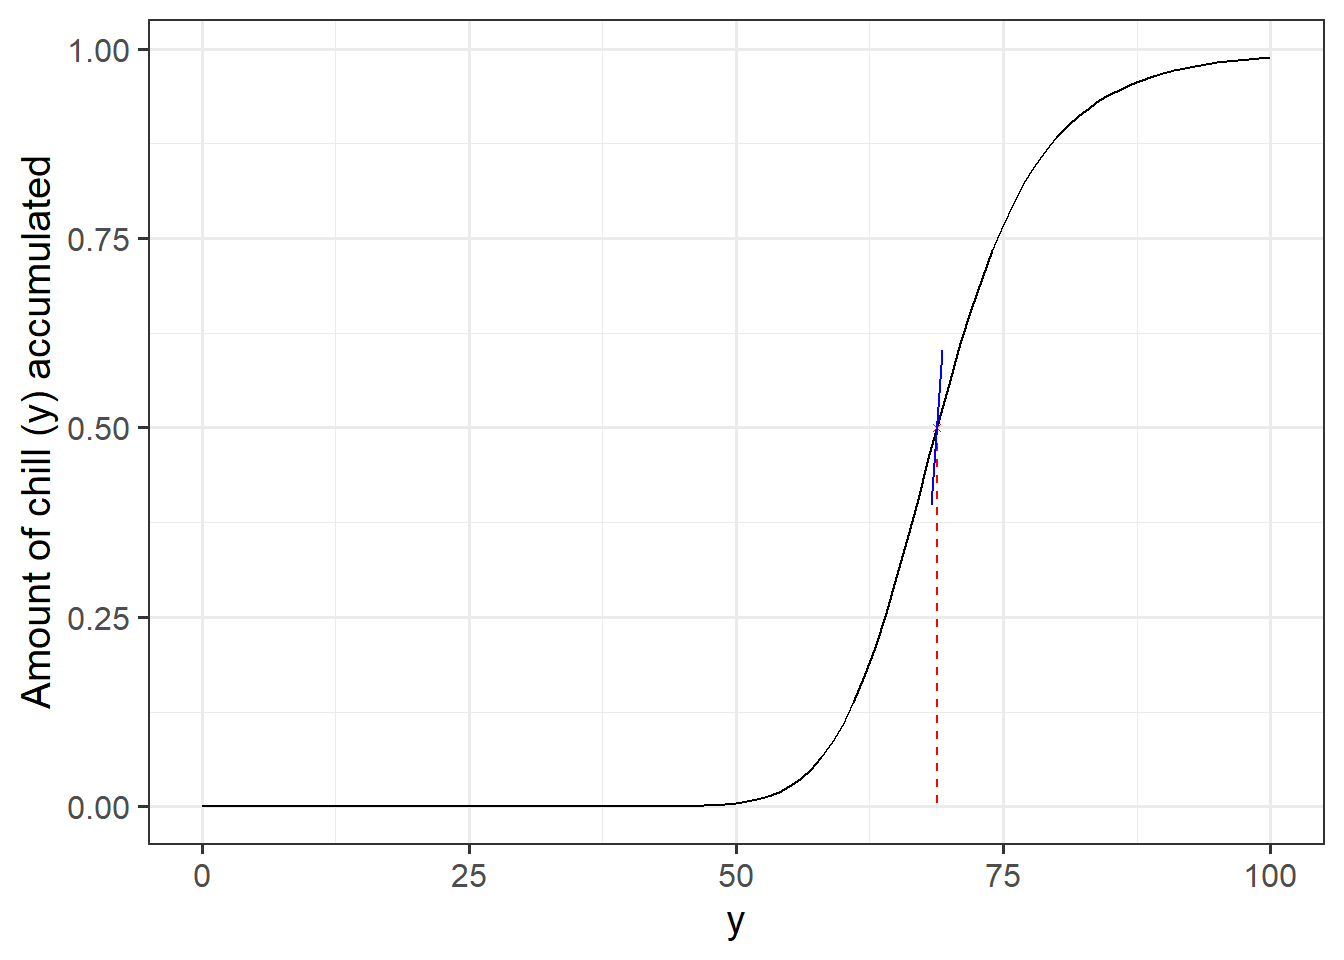

In [ ]:
#vizualize also the transition parameters. yc and s1
get_share_heat <- function(y, yc, s1){
  sr <- exp(s1 * yc * ((y - yc)/y))
  return((sr) / (1+sr))
}

s1 <- 1
yc <- 40
y <- 40


curve_df <- purrr::map(1:nrow(par_all), function(i){
  curve <- get_share_heat(0:100, par_all[i,'yc'], par_all[i,'s1'])
  return(data.frame(y = 0:100,
                    yc = par_all[i,'yc'],
                    s1 = par_all[i,'s1'],
                    share_heat = curve,
                    species = par_all$species[i],
                    cultivar = par_all$cultivar[i],
                    fit = par_all$fit[i],
                    n_cal = par_all$n_cal[i]))
  
}) 
curve_df <- do.call('rbind', curve_df)

#calculate the yintercept for the line around the infliction point
vector_length <- 0.5
step_right <- 1

curve_df %>%    mutate(fit_plot = factor(fit,                             levels = c('baseline', 'single', 'combined'),                            labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit'))) %>%    mutate(id = paste(species, cultivar, fit, n_cal, sep = '_'),          a = 0.5 - (s1*yc),          x_start = yc-step_right,          x_end = yc+step_right,          y_start = a + s1 *x_start,          y_end = a + s1 * x_end) %>%    mutate(x_vec = x_start - x_end,          y_vec = y_start - y_end,          length = sqrt(x_vec^2 + y_vec^2),          x_einheit = x_vec / length,          y_einheit = y_vec / length,          x_plot_start = yc - (x_einheit*vector_length),          x_plot_end = yc + (x_einheit*vector_length),          y_plot_start = 0.5 - (y_einheit*vector_length),          y_plot_end = 0.5 + (y_einheit * vector_length)) %>%    filter(cultivar == 'Schneiders', fit == 'combined', n_cal == 'full') %>%    ggplot(aes(x = y, y = share_heat, group = id)) +   geom_line(show.legend = FALSE) +   geom_segment(aes(y = 0.5, yend = 0, x = yc, xend = yc), col = 'red',                linetype = 'dashed') +   geom_point(aes(y = 0.5, x = yc), col = 'red',              shape = 4, size = 1) +   geom_segment(aes(y = y_plot_start,                    yend = y_plot_end,                    x = x_plot_start,                    xend = x_plot_end),                col = 'blue') +   theme_bw(base_size = 15) +   ylab('Share of potential heat that gets accumulated') +   ylab('Amount of chill (y) accumulated') 

First is a plot that depicts how different values in s1 lead to different transition curves.

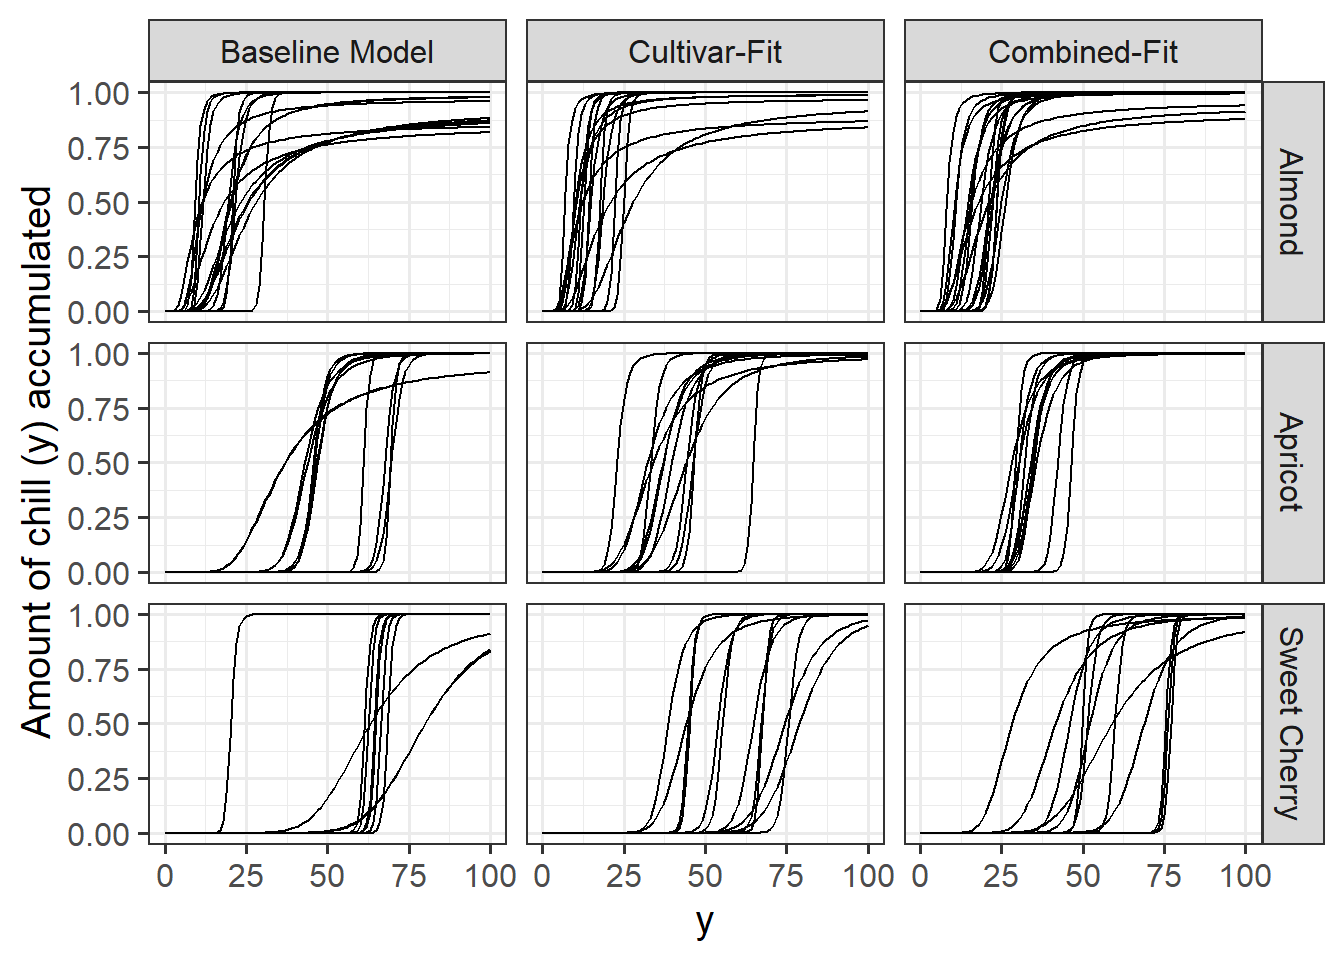

In [ ]:
curve_df %>% 
  mutate(fit_plot = factor(fit, 
                           levels = c('baseline', 'single', 'combined'),
                           labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit'))) %>% 
  mutate(id = paste(species, cultivar, fit, n_cal, sep = '_'),
         a = 0.5 - (s1*yc),
         x_start = yc-step_right,
         x_end = yc+step_right,
         y_start = a + s1 *x_start,
         y_end = a + s1 * x_end) %>% 
  mutate(x_vec = x_start - x_end,
         y_vec = y_start - y_end,
         length = sqrt(x_vec^2 + y_vec^2),
         x_einheit = x_vec / length,
         y_einheit = y_vec / length,
         x_plot_start = yc - (x_einheit*vector_length),
         x_plot_end = yc + (x_einheit*vector_length),
         y_plot_start = 0.5 - (y_einheit*vector_length),
         y_plot_end = 0.5 + (y_einheit * vector_length)) %>% 
  ggplot(aes(x = y, y = share_heat, group = id)) +
  geom_line(show.legend = FALSE) +
  # geom_segment(aes(y = 0.5, yend = 0, x = yc, xend = yc), col = 'red',
  #              linetype = 'dashed') +
  # geom_point(aes(y = 0.5, x = yc), col = 'red',
  #            shape = 4, size = 1) +
  # geom_segment(aes(y = y_plot_start,
  #                  yend = y_plot_end,
  #                  x = x_plot_start,
  #                  xend = x_plot_end),
  #              col = 'blue') +
  theme_bw(base_size = 15) +
  ylab('Share of potential heat that gets accumulated') +
  ylab('Amount of chill (y) accumulated') +
  facet_grid(species~fit_plot)

Same plot but with color differentiation among the cultivars.

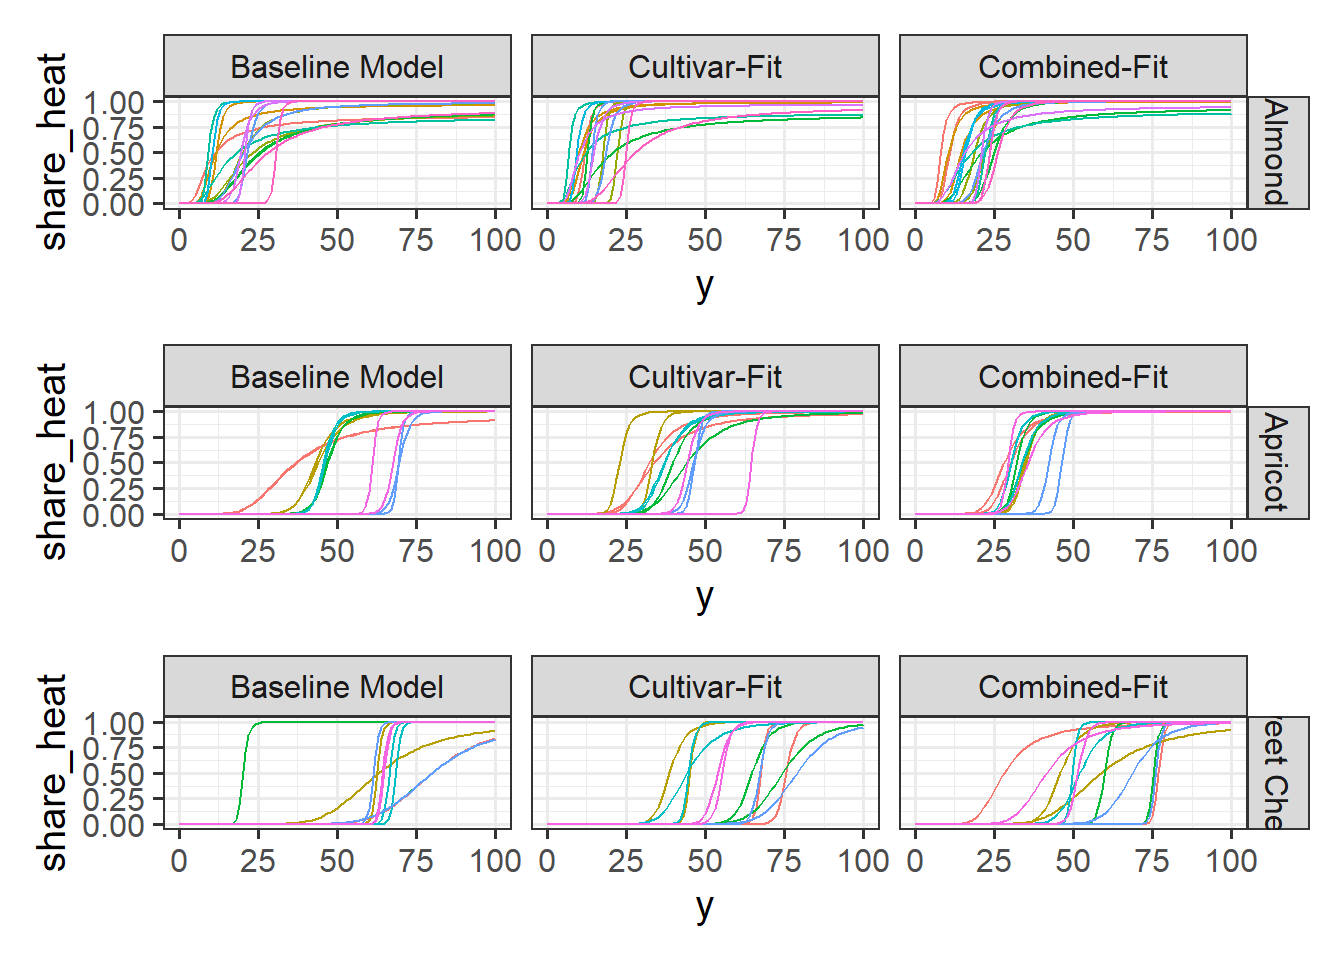

In [ ]:
p1 <- curve_df %>% 
  filter(species == 'Almond') %>% 
  mutate(fit_plot = factor(fit, 
                           levels = c('baseline', 'single', 'combined'),
                           labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit'))) %>% 
  mutate(id = paste(species, cultivar, fit, n_cal, sep = '_')) %>% 
  ggplot(aes(x = y, y = share_heat, group = id, col = cultivar)) +
  geom_line(show.legend = FALSE) +
  theme_bw(base_size = 15) +
  facet_grid(species~fit_plot) 

p2 <- curve_df %>% 
  filter(species == 'Apricot') %>% 
  mutate(fit_plot = factor(fit, 
                           levels = c('baseline', 'single', 'combined'),
                           labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit'))) %>% 
  mutate(id = paste(species, cultivar, fit, n_cal, sep = '_')) %>% 
  ggplot(aes(x = y, y = share_heat, group = id, col = cultivar)) +
  geom_line(show.legend = FALSE) +
  theme_bw(base_size = 15) +
  facet_grid(species~fit_plot) 

p3 <- curve_df %>% 
  filter(species == 'Sweet Cherry') %>% 
  mutate(fit_plot = factor(fit, 
                           levels = c('baseline', 'single', 'combined'),
                           labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit'))) %>% 
  mutate(id = paste(species, cultivar, fit, n_cal, sep = '_')) %>% 
  ggplot(aes(x = y, y = share_heat, group = id, col = cultivar)) +
  geom_line(show.legend = FALSE) +
  theme_bw(base_size = 15) +
  facet_grid(species~fit_plot) 

library(patchwork)
p1/p2/p3

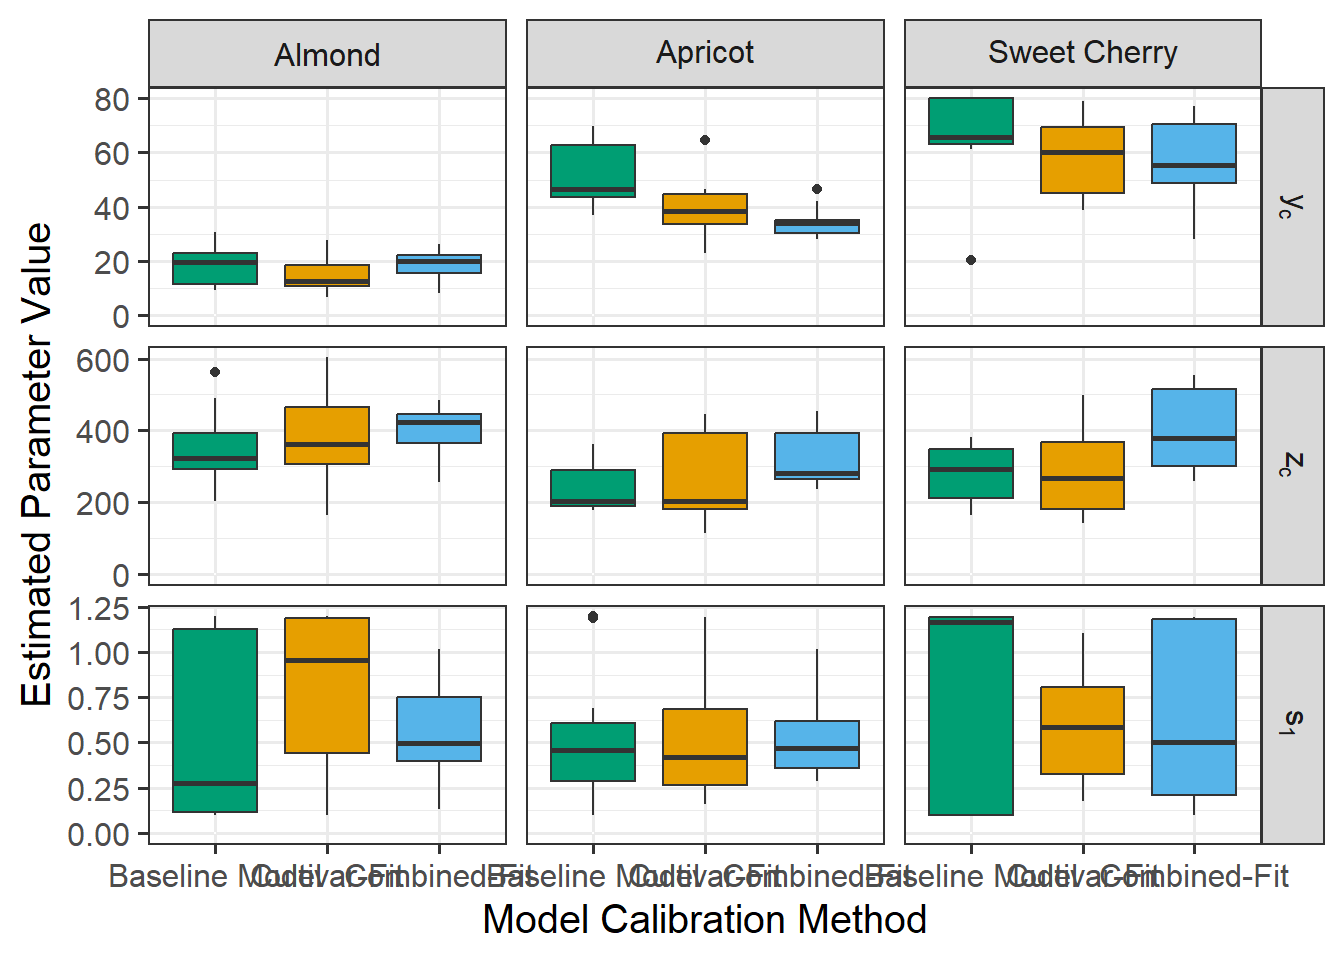

In [ ]:
force_label <- data.frame(species_label = factor('Almond',
                                                 levels = c('Almond', 'Apricot', 'Sweet Cherry'),
                                                 labels = c('Almond', 'Apricot', 'Sweet~Cherry')),
                          fit_plot = factor('baseline', 
                                            levels = c('baseline', 'single', 'combined'),
                                            labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit')),
                          name = factor(c('yc', 'zc', 's1'),
                                        levels = c('yc', 'zc', 's1'),
                                        labels = c('y[c]', 'z[c]','s[1]')),
                          value = rep(0,3))

par_all %>% 
  mutate(fit_plot = factor(fit, 
                           levels = c('baseline', 'single', 'combined'),
                           labels = c('Baseline Model', 'Cultivar-Fit', 'Combined-Fit'))) %>%
  pivot_longer(cols = c('yc', 'zc', 's1')) %>% 
  mutate(name = factor(name,
                       levels = c('yc', 'zc', 's1'),
                       labels = c('y[c]', 'z[c]','s[1]')),
         species_grid = factor(species,
                               levels = c('Almond', 'Apricot', 'Sweet Cherry'),
                               labels = c('Almond', 'Apricot', 'Sweet~Cherry'))) %>% 
  ggplot(aes(x = fit_plot, y = value, fill = fit_plot)) +
  geom_boxplot() +
  geom_point(data = force_label, col = 'white', size = 0.1) +
  scale_fill_manual(name = 'Calibration Method', values = c("#009E73", "#E69F00", "#56B4E9")) +
  facet_grid(name~species_grid, scales ='free_y', labeller = label_parsed) +
  theme_bw(base_size = 15) +
  ylab('Estimated Parameter Value') +
  xlab('Model Calibration Method') +
  theme(legend.position = 'none')

Summary table for the input data

In [ ]:
#table for text
master %>% 
  filter(ncal == 'full') %>% 
  group_by(species, location) %>% 
  summarise(n = n(),
            start = min(year),
            end = max(year))

`summarise()` has grouped output by 'species'. You can override using the
`.groups` argument.

# A tibble: 7 × 5
# Groups:   species [3]
  species      location            n start   end
  <chr>        <chr>           <int> <int> <int>
1 Almond       Meknes            117  1974  2014
2 Almond       Santomera          48  1997  2022
3 Almond       Sfax               67  1981  2016
4 Apricot      Cieza              41  2003  2022
5 Apricot      Zaragoza           86  1999  2022
6 Sweet Cherry Klein-Altendorf    93  1978  2020
7 Sweet Cherry Zaragoza           72  1991  2022